<a href="https://colab.research.google.com/github/MariaPetrovskaya/Natural-Language-Processing/blob/main/Text%20complexity%20levels/Classification_of_text_complexity_levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About project

###Introduction

*   Watching films in the original language is a popular and effective method  for training languages skills.
*   It is important to choose a film that suits actual level of difficulty, (possible to understood 50-70% of the dialogues).
*   To fulfill this condition, the expert must watch the new film and decide what level it corresponds to. However, this requires a lot of time.


###Business task

*   Customer of this product: the foreign language courses.
*   Develop an ML solution (multi-class classification) for prediction of difficulty levels for English-language films.









###Initial data

*   Subtitles of films saved in directories with names as level of difficulty according to the CEFR ([Common European Framework of Reference]('https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%89%D0%B5%D0%B5%D0%B2%D1%80%D0%BE%D0%BF%D0%B5%D0%B9%D1%81%D0%BA%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B5%D1%82%D0%B5%D0%BD%D1%86%D0%B8%D0%B8_%D0%B2%D0%BB%D0%B0%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B8%D0%BD%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%BD%D1%8B%D0%BC_%D1%8F%D0%B7%D1%8B%D0%BA%D0%BE%D0%BC' 'wikipedia'))
*   Movie subtitles in XLSX files containing the name of the movies and the degree of difficulty according to the CEFR scale
*   List of words, according to Oxford level of difficulty



In [ ]:
%%capture
# need to install in colab
!pip install pysrt
!pip install spacy
!pip install tabula-py
!pip install catboost # open source library for gradient boosting on decision trees

In [ ]:
# imports
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     StratifiedShuffleSplit,
                                     GridSearchCV
                                     )
from sklearn.pipeline import (Pipeline,
                              FeatureUnion
                              )

from sklearn.metrics import (classification_report,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay
                             )
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             CountVectorizer
                                             )
from sklearn.base import (BaseEstimator,
                          TransformerMixin
                          )
import pickle
import pysrt
import spacy
import nltk
from nltk.corpus import stopwords

import requests
import urllib
import json
import zipfile
from zipfile import ZipFile
import tabula
from tabula import read_pdf
from catboost import Pool, CatBoostClassifier

In [ ]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer for selecting column for
    additional transformations,
    for numeric columns
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer for selecting column for
    additional transformations,
    for text columns
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]




# Data Loading and Preprocessing



###Loadind data with movies

In [ ]:
#import from с Google Disk to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/datasets'
path_to_zip_file = f'{PATH}/English_scores.zip'
path_to_zip_file

'/content/drive/MyDrive/datasets/English_scores.zip'

In [ ]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  znm = zObject.namelist()

In [ ]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  movies_labels = zObject.extract('movies_labels.xlsx')

In [ ]:
#loading dataset with movies levels
df = pd.read_excel(movies_labels, index_col='id')
df.info

<bound method DataFrame.info of                                 Movie   Level
id                                           
0           10_Cloverfield_lane(2016)      B1
1    10_things_I_hate_about_you(1999)      B1
2                A_knights_tale(2001)      B2
3                A_star_is_born(2018)      B2
4                       Aladdin(1992)  A2/A2+
..                                ...     ...
236                     Matilda(2022)      C1
237                      Bullet train      B1
238            Thor: love and thunder      B2
239                         Lightyear      B2
240                        The Grinch      B1

[241 rows x 2 columns]>

In [ ]:
# looking list of levels
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

In [ ]:
# assign a numeric values to the levels
label_dict = {'A2': 1,
              'A2/A2+': 1,
              'B1': 2,
              'A2/A2+, B1': 2,
              'B2': 3,
              'B1, B2': 3,
              'C1': 4}
# change levels to numeric values
df['Level'] = df['Level'].replace(label_dict)

In [ ]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(238, 2)

###Loading subtitles

In [ ]:
films_name = {}
for srt in znm:
  if srt.find('.srt') != -1 and srt.find('__MACOSX') == -1:
    films_name[srt.split('/')[-1]] = srt
print(len(films_name))

278


In [ ]:
# checking number of films from table with subtitles
films_filtr = set(films_name.keys()) & set(df['Movie'] + '.srt')
len(films_filtr)

229

In [ ]:
def load_subs(film):
  """loading subtitles function"""
  fsrt = f'{film}.srt'
  if fsrt not in set(films_name.keys()):
    return None
  with ZipFile(path_to_zip_file, 'r') as zObject:
    f = zObject.extract(films_name[fsrt])
    try:
      subs = pysrt.open(f)
    except:
      subs = pysrt.open(f,encoding='iso-8859-1')
  return subs

In [ ]:
%%time
#loading subtitles
df['subs'] = df['Movie'].apply(load_subs)

CPU times: user 11 s, sys: 342 ms, total: 11.4 s
Wall time: 15.5 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df['subs']

id
0      [1\n00:00:55,279 --> 00:01:07,279\n<font color...
1      [1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n...
2      [1\n00:00:15,089 --> 00:00:21,229\nResync: Xen...
3      [1\n00:00:17,610 --> 00:00:22,610\n- <i><font ...
4      [1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co...
                             ...                        
236                                                 None
237                                                 None
238                                                 None
239                                                 None
240                                                 None
Name: subs, Length: 238, dtype: object

In [ ]:
#dropping gaps
df = df.dropna().reset_index(drop=True)

In [ ]:
df

,Movie,Level,subs
0,10_Cloverfield_lane(2016),2,"[1\n00:00:55,279 --> 00:01:07,279\n<font color..."
1,10_things_I_hate_about_you(1999),2,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n..."
2,A_knights_tale(2001),3,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen..."
3,A_star_is_born(2018),3,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ..."
4,Aladdin(1992),1,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co..."
...,...,...,...
225,Suits.S03E06.720p.HDTV.x264-mSD,4,"[1\n00:00:01,383 --> 00:00:02,751\nI lost Ava ..."
226,Suits.S03E07.HDTV.x264-mSD,4,"[1\n00:00:00,052 --> 00:00:01,352\nPreviously ..."
227,Suits.S03E08.480p.HDTV.x264-mSD,4,"[1\n00:00:01,436 --> 00:00:03,028\nI get Ava H..."
228,Suits.S03E09.480p.HDTV.x264-mSD,4,"[1\n00:00:00,024 --> 00:00:01,478\nPreviously ..."


###Data imbalances

In [ ]:
df['Level'].value_counts()

3    105
2     55
4     39
1     31
Name: Level, dtype: int64

###Splitting data into training and test samples

In [ ]:
STATE = 0
df_train, df_test = train_test_split(df, random_state=STATE,
                                    test_size=0.25,
                                    stratify=df['Level'])
X = df_train.drop(['Level','Movie'], axis=1)
y = df_train['Level']
X_test = df_test.drop(['Level','Movie'], axis=1)
y_test = df_test['Level']
print(f'train size: {X.shape, y.shape}')
print(f'test size: {X_test.shape, y_test.shape}')

train size: ((172, 1), (172,))
test size: ((58, 1), (58,))


###Subtitle text preprocessing

In [ ]:
# set regular expressions for text preprocessing
HTML = r'<.*?>' # html tags
#TAG = r'{.*?}' # change tags to spaces
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # comments in parentheses
LETTERS = r'[^\w\s]' # anything that isn't a letter
SPACES = r'([ ])\1+' # repeated spaces
DOTS = r'[\.]+' # punctuation mark ellipsis
SYMB = r"[^\w\d'\s]" # punctuation marks other than apostrophe
def clean_subs(subs):
  """subtitle text preprocessing"""
  subs = subs[1:] # remove the first promotional subtitle
  txt = re.sub(HTML, ' ', subs.text) # html tags change to spaces
  txt = re.sub(COMMENTS, ' ', txt) # comments in parentheses change to spaces
  txt = re.sub(LETTERS, ' ', txt) # anything that isn't a letter is a space
  txt = re.sub(DOTS, r'.', txt) # punctuation mark ellipsis change to dots
  txt = re.sub(SPACES, r'\1', txt) # repeated spaces change to one space
  txt = re.sub(SYMB, '', txt) # punctuation marks other than apostrophe change to an empty string
  txt = re.sub('www', '', txt) # 'www' change to an empty string
  txt = txt.lstrip().rstrip().replace("\n","") # left space trimming
  txt = txt.encode('ascii', 'ignore').decode() # remove all non-ascii characters
  txt = txt.lower() # to lowercase
  txt = ' '.join(txt.split())
  return txt

In [ ]:
%%time
X['subs'] = X['subs'].apply(clean_subs)
X['subs']

CPU times: user 1.13 s, sys: 4.62 ms, total: 1.14 s
Wall time: 1.15 s


20     our first guest he s made a career outof being...
163    i ever brought into the firm i have stacked my...
28     rhythmic thumping musicplaying my planetarraki...
35     my name s forrest forrest gump do you want a c...
166    i am placing harvey specteron immediate unpaid...
                             ...                        
226    it s going upon the wall tomorrow and this is ...
26     what gives you that idea you want to know the ...
57     thank you so how does it feelbeing back after ...
220    you win you get what you want you lose you sta...
119    our planet looked very differentfrom what it d...
Name: subs, Length: 172, dtype: object

###Loading dictionaries

In [ ]:
path_to_zip_file = f'{PATH}/Oxford_CEFR_level.zip'
with ZipFile(path_to_zip_file, 'r') as zObject:
  Oxf3 = zObject.extract('The_Oxford_3000_by_CEFR_level.pdf')
  Oxf5 = zObject.extract('The_Oxford_5000_by_CEFR_level.pdf')

In [ ]:
pdf3000 = tabula.read_pdf(Oxf3,
                      pages='all',
                      stream=True,
                      guess=False,
                      pandas_options={'header': None})
print(f'number of pages The_Oxford_3000_by_CEFR_level: {len(pdf3000)}')

number of pages The_Oxford_3000_by_CEFR_level: 12


In [ ]:
pdf5000 = tabula.read_pdf(Oxf5,
                      pages='all',
                      stream=True,
                      guess=False,
                      pandas_options={'header': None})
print(f'number of pages The_Oxford_5000_by_CEFR_level в tabula: {len(pdf5000)}')

number of pages The_Oxford_5000_by_CEFR_level в tabula: 8


In [ ]:
wordlist = []

def df_to_list(df,wordlist):
  """selects all words from the dictionary and put them in the list"""
  for col in df.columns:
    #tabula can put several rows in one cell, we need to separate them
    tmpdf = df[col].astype('string').str.split(' ', expand= True)
    for col in tmpdf.columns:
      rcol = tmpdf[tmpdf[col].notna()][col].str.lower()
      #leaving only the words
      rcol = rcol[rcol.str.isalpha()]
      wordlist = wordlist + list(rcol.unique())
  return  wordlist

for i in range(0,len(pdf3000)):
  wordlist = df_to_list(pdf3000[i], wordlist)

for i in range(0,len(pdf5000)):
  wordlist = df_to_list(pdf5000[i], wordlist)

In [ ]:
a2 = wordlist.index('ability') #first word index of level a2
b1 = wordlist.index('absolutely')#first word index of level b1
b2 = wordlist.index('abandon')#first word index of level b2
c1 = wordlist.index('abolish')#first word index of level с1
levels = ['A2','B1','B2','C1']
vlev = {levels[0] : set(wordlist[a2:b1]),
        levels[1]: set(wordlist[b1:b2]),
        levels[2]: set(wordlist[b2:c1]),
        levels[3]: set(wordlist[c1:]),
        }

###Imbalance of dictionary classes

In [ ]:
for level in levels:
  print(level,'=',len(vlev[level]))

A2 = 866
B1 = 807
B2 = 1433
C1 = 1308


#Machine Learning

###Feature modeling

In [ ]:
def count_percent_words_dictionar(sub):
  """counts the percentage of lemms in dictionaries"""
  nlp = spacy.load('en_core_web_sm' )
  doc = nlp(sub)
  lms = set([token.lemma_ for token in doc])
  lem_per = [(len(lms&vlev[level])/len(lms))*100 for level in levels]
  return lem_per

In [ ]:
%%time
levpercent = [f'{_}+percent' for _ in levels]
X.loc[:,levpercent] = X['subs'].apply(count_percent_words_dictionar).to_list()
X

CPU times: user 6min 11s, sys: 8.32 s, total: 6min 19s
Wall time: 6min 24s


,subs,A2+percent,B1+percent,B2+percent,C1+percent
20,our first guest he s made a career outof being...,15.127701,9.282908,8.398821,3.732809
163,i ever brought into the firm i have stacked my...,12.868440,7.979871,7.692308,2.300503
28,rhythmic thumping musicplaying my planetarraki...,14.320242,8.640483,9.788520,4.048338
35,my name s forrest forrest gump do you want a c...,15.362812,9.013605,7.312925,2.721088
166,i am placing harvey specteron immediate unpaid...,11.126374,7.348901,7.829670,3.228022
...,...,...,...,...,...
226,it s going upon the wall tomorrow and this is ...,11.973244,7.959866,7.491639,3.478261
26,what gives you that idea you want to know the ...,14.508929,9.263393,9.207589,3.962054
57,thank you so how does it feelbeing back after ...,16.900093,10.457516,12.418301,4.761905
220,you win you get what you want you lose you sta...,11.989101,7.493188,8.106267,3.133515


###Feature analysis


In [ ]:
for lev in range(1,5):
  print(f'Level-{lev}')
  print(X[y==lev][levpercent].describe().round(2))
  print()

Level-1
       A2+percent  B1+percent  B2+percent  C1+percent
count       23.00       23.00       23.00       23.00
mean        15.89        9.43        9.30        3.64
std          2.27        1.44        1.71        1.05
min         11.61        6.84        6.67        2.22
25%         14.74        8.36        8.15        2.81
50%         16.36        9.61        9.24        3.60
75%         17.08       10.31       10.64        4.15
max         19.79       12.66       13.28        6.55

Level-2
       A2+percent  B1+percent  B2+percent  C1+percent
count       41.00       41.00       41.00       41.00
mean        15.72        9.63        9.63        3.55
std          1.78        1.20        1.65        0.73
min         12.34        7.00        6.95        1.41
25%         14.60        8.80        8.51        3.15
50%         15.44        9.46        9.21        3.71
75%         16.90       10.62       10.36        3.98
max         19.05       12.48       12.95        4.81

Level-3
  

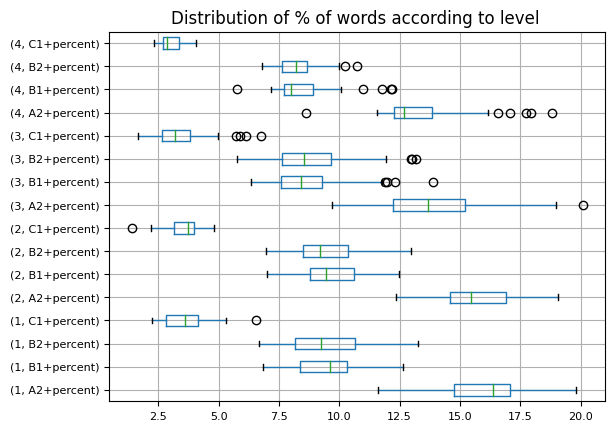

In [ ]:
title='Distribution of % of words according to level '
ax = X.groupby(y).boxplot(subplots=False,
                     fontsize=8,
                     vert=False,
                     grid =True,
                     )
ax.set_title(title)
plt.show()

###  Feature Importance with CatBoost

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=STATE,
                                    test_size=0.25,
                                    stratify=y)
train_pool = Pool(X_train, y_train, text_features=['subs'])
test_pool = Pool(X_valid, y_valid, text_features=['subs'])
params = {
    'objective': 'MultiClass',
    'random_state': STATE,
    'verbose': 1,
    "eval_metric" : 'TotalF1',
    "early_stopping_rounds" : 10
    }
model2 = CatBoostClassifier(**params)
model2.fit(train_pool, eval_set=test_pool, plot=False)

Learning rate set to 0.103643
0:	learn: 0.7166757	test: 0.3385013	best: 0.3385013 (0)	total: 2.47s	remaining: 41m 8s
1:	learn: 0.7915310	test: 0.4031008	best: 0.4031008 (1)	total: 5.15s	remaining: 42m 52s
2:	learn: 0.7562577	test: 0.3208560	best: 0.4031008 (1)	total: 7.91s	remaining: 43m 50s
3:	learn: 0.7738980	test: 0.3641131	best: 0.4031008 (1)	total: 9.51s	remaining: 39m 28s
4:	learn: 0.7856662	test: 0.3927980	best: 0.4031008 (1)	total: 10.6s	remaining: 35m 7s
5:	learn: 0.7928679	test: 0.4406915	best: 0.4406915 (5)	total: 11.6s	remaining: 32m 2s
6:	learn: 0.7836557	test: 0.4727191	best: 0.4727191 (6)	total: 12.6s	remaining: 29m 50s
7:	learn: 0.7937018	test: 0.4919323	best: 0.4919323 (7)	total: 13.6s	remaining: 28m 10s
8:	learn: 0.8022117	test: 0.4928778	best: 0.4928778 (8)	total: 14.6s	remaining: 26m 51s
9:	learn: 0.8028860	test: 0.4928778	best: 0.4928778 (8)	total: 15.7s	remaining: 25m 51s
10:	learn: 0.8061701	test: 0.4333333	best: 0.4928778 (8)	total: 16.7s	remaining: 25m 1s
11:	l

Text(0.5, 1.0, 'Feature Importance')

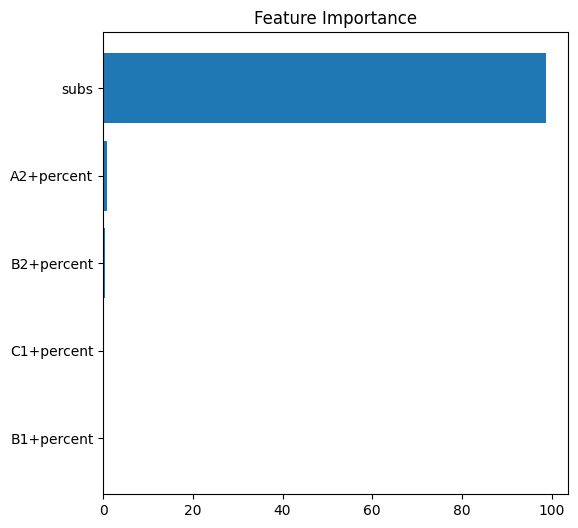

In [ ]:
feature_importance = model2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

Result: adding of new features does not affect quality  of the models

###Choosing the metric


*   The class imbalance was previously discovered.
*   Both 'precision' and 'recall' are equally important to the practical task.
*   The best metric is a harmonic mean of 'precision' and 'recall' - F1-measure - will be taken F1-weighted.


### Pipeline

In [ ]:
report = pd.DataFrame(columns = ['model',
                                 'classificator',
                                 'vectorizer',
                                 'hparams',
                                 'F1 score'
                                 ])

In [ ]:
a2 =  Pipeline([
                ('selector', NumberSelector(key='A2+percent')),
                ('standard', MinMaxScaler())
            ])
b1 =  Pipeline([
                ('selector', NumberSelector(key='B1+percent')),
                ('standard', MinMaxScaler())
            ])
b2 =  Pipeline([
                ('selector', NumberSelector(key='B2+percent')),
                ('standard', MinMaxScaler())
            ])
c1 =  Pipeline([
                ('selector', NumberSelector(key='C1+percent')),
                ('standard', MinMaxScaler())
            ])

In [ ]:
vects = [[('vec', CountVectorizer(stop_words='english')),
          {
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ],
         [('vec', TfidfVectorizer(stop_words='english')),
{
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ]]

clfs = [[SGDClassifier(random_state=STATE),
         {'classifier__alpha': [0.001, 0.01, 0.1]}
         ],
          [MultinomialNB(),
           {'classifier__alpha': [0.5, 1]}
         ]]

###Training model

In [ ]:
%%time
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=6,
                                                  test_size=0.25,
                                                  random_state=STATE)
for vec in vects:
  vecpipe = Pipeline([('selector', TextSelector(key='subs')),
                      vec[0]
                      ])
  vecpipe.fit_transform(X)
  featscountvector = FeatureUnion([('text', vecpipe),
                      ('A2+percent', a2),
                      ('B1+percent', b1),
                      ('B2+percent', b2),
                      ('C1+percent', c1),
                        ])

  feature_processing = Pipeline([('feats', featscountvector)])
  feature_processing.fit_transform(X)

  for clf in clfs:
    clfpipeline = Pipeline([
        ('features', featscountvector),
        ('classifier', clf[0]),
    ])
    hyperparameters = vec[1]|clf[1]
    clfpipegridcv = GridSearchCV(clfpipeline,
                                hyperparameters,
                                cv=stratified_shuffle_split,
                                scoring='f1_weighted'
                                )
    clfpipegridcv.fit(X, y)
    report.loc[len(report)]=[clfpipegridcv.best_estimator_,
                             str(clf[0]),
                             str(vec[0]),
                             str(clfpipegridcv.best_params_),
                             clfpipegridcv.best_score_
                             ]
report = report.sort_values(by='F1 score',ascending=False)
report.reset_index(drop= True , inplace= True )
report

CPU times: user 23min 56s, sys: 50.3 s, total: 24min 46s
Wall time: 24min 22s


,model,classificator,vectorizer,hparams,F1 score
0,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 1, 'features__text__vec_...",0.698449
1,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.001, 'features__text__...",0.679014
2,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 0.1, 'features__text__ve...",0.631287
3,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.5, 'features__text__ve...",0.333369


In [ ]:
#select best mоdel
clf = report['model'].loc[0]
clf.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='subs')),
                                                                 ('vec',
                                                                  CountVectorizer(min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english'))])),
                                                ('A2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='A2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('C1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='C1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())]))])),
                ('classifier', MultinomialNB(alpha=1))])

##Testing model

In [ ]:
X_test['subs'] = X_test['subs'].apply(clean_subs)
X_test.loc[:,levpercent] = X_test['subs'].apply(count_percent_words_dictionar).to_list()

              precision    recall  f1-score   support

           1       1.00      0.12      0.22         8
           2       0.46      0.79      0.58        14
           3       0.87      0.77      0.82        26
           4       1.00      1.00      1.00        10

    accuracy                           0.72        58
   macro avg       0.83      0.67      0.65        58
weighted avg       0.81      0.72      0.71        58



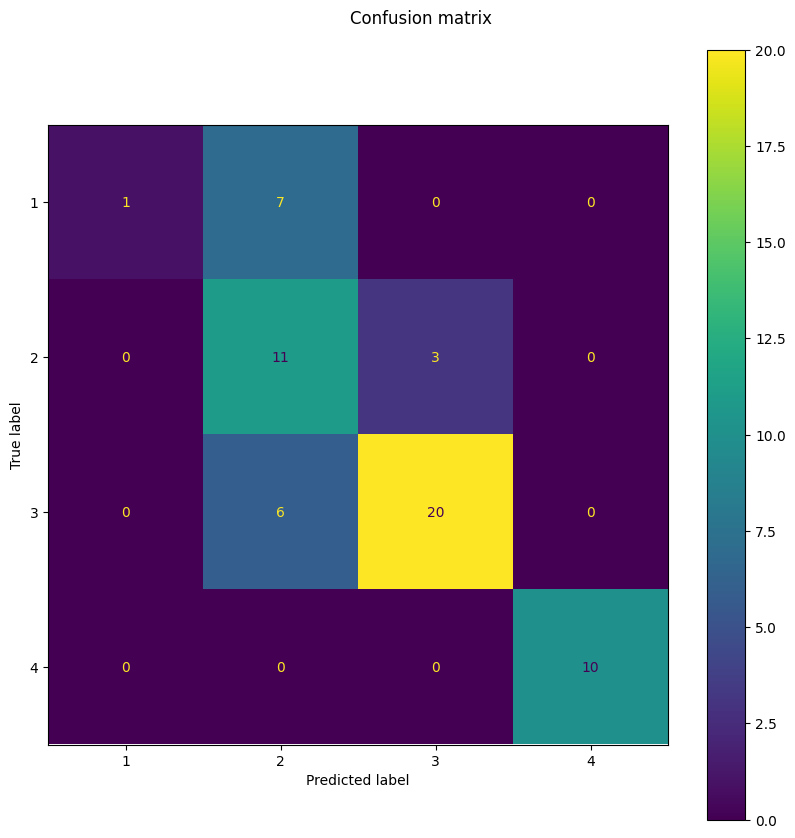

In [ ]:
def plot_confusion_matrix(y_test, y_preds, model):
  """confusion matrix """
  fig, ax = plt.subplots(figsize=(10,10))
  cm = confusion_matrix(y_test, y_preds)
  cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
  cmp.plot(ax=ax)
  plt.suptitle('Confusion matrix ', y=0.92)
  plt.show()
predictions =clf.predict(X_test)
# Compute and plot confusion matrix
print(classification_report(y_test, predictions))
plot_confusion_matrix(y_test, predictions, clf)

##Results of the model on the test selection

*   MultinomialNB() model is most often wrong on boundary label
*   The F1 weighted metric on the test was 0.71.


#Summary results


*   Created NumberSelector and TextSelector functions.
*   Data was loaded and preprocessed.
*  Data was split into training and test samples.  
*   Adding additional features: the percentage of unique lemmas contained in each subtitle text according to the level of difficulty according to the Oxford Classical Dictionary.
*   Feature importance was evaluated with CatBoost.
*    For searching best hyperparameters used machine learning algorithm with pipeline, GridSearchCV.
*   For converting subtitle text into a compact sparse matrix used CountVectorizer, TfidfVectorizer.
*   The models for classification were MultinomialNB, SGDClassifier.
*   The search of the best hyperparameters was done on the training subsets and validated on the test subsets.
*   The F1 weighted metric on the test was 0.71.


##Saving model

In [ ]:
# saving best model
clf

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='subs')),
                                                                 ('vec',
                                                                  CountVectorizer(min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english'))])),
                                                ('A2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='A2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('C1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='C1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())]))])),
                ('classifier', MultinomialNB(alpha=1))])

In [ ]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)